In [29]:
import os
import torch
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch.mps 
import itertools
import csv

# plt.ion() 
plt.gray()


<Figure size 640x480 with 0 Axes>

In [30]:
# %%time
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("MPS found")
    device = torch.device("mps")
    

MPS found


In [31]:
class FERPlusDataset(Dataset):
    """FERPlus dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_frame)

#     to access elements using the []
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

#   to create the image name
        img_name = os.path.join(self.root_dir, self.img_frame.iloc[idx, 0])

        image = io.imread(img_name)
        emotions = self.img_frame.iloc[idx, 2:]
        emotions = np.asarray(emotions)
        emotions = emotions.astype('float32')

        sample = {'image': image, 'emotions': emotions} # a dictionary of an image with its label
        if self.transform:
            sample = self.transform(sample)

        return sample #return a transformed image with label
    
    def to(self, device):
        # move to device
        return self.to(device)
        

In [32]:
#     class to transform to a normalized tensor (only the image pixel value is transformed)
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, emotions = sample['image'], sample['emotions']
        transform = transforms.ToTensor()

        return {'image': transform(image),
                'emotions': emotions}

In [33]:
train_folder_path = './data/FER2013Train'
test_folder_path = './data/FER2013Test'
valid_folder_path = './data/FER2013Valid'

In [34]:
train_dataset = FERPlusDataset(os.path.join(train_folder_path,"label.csv"), train_folder_path, transform=ToTensor())
valid_dataset = FERPlusDataset(os.path.join(valid_folder_path, "label.csv"), valid_folder_path, transform=ToTensor())
test_dataset = FERPlusDataset(os.path.join(test_folder_path, "label.csv"), test_folder_path, transform=ToTensor())


In [35]:
def train_and_validate(epochs, optimizer, scheduler ,criterion, model, trainloader, validloader, learning_rate,):
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    opt_name = optimizer.__name__
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    
    if scheduler == optim.lr_scheduler.ReduceLROnPlateau:
        scheduler = scheduler(optimizer)
        # print("plateu")
        # print(type(scheduler))
        
    elif scheduler == optim.lr_scheduler.ExponentialLR: 
        scheduler = scheduler(optimizer, gamma=0.9)
        # print(type(scheduler))
        
    st = time.time()

# Training - Validation loop
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        model.train()
        # Perform training
        for i, data in enumerate(trainloader, 0):
            # labels = data['emotions']
            # inputs = data['image']
            labels = data['emotions'].to(device)
            inputs = data['image'].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # print("label before: ", labels)
            # print("predicted before: ", outputs)
            # Calculate and store training accuracy
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            
            # print("label: ", labels)
            # print("predicted: ", predicted)
            # print("pred size: " , predicted.shape)
            total += labels.size(0)
            correct +=  (predicted == labels).sum().item()
            # print("1 more correct..")
        
              
        scheduler.step()
                
        train_loss.append(running_loss / len(trainloader))
        train_accuracy.append(100 * correct / total)
        
        # Perform validation
        model.eval()
        correct = 0
        total = 0
        running_loss = 0.0
        
        with torch.inference_mode():
            for data in validloader:
                # labels = data['emotions']
                # images = data['image']
                labels = data['emotions'].to(device)
                images = data['image'].to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                _, labels = torch.max(labels, 1)
                
                total += labels.size(0)
                # print("total: " , total)
                correct +=  (predicted == labels).sum().item() #can be torch.eq(pred, labels).sum().item()
        
        valid_loss.append(running_loss / len(validloader))
        valid_accuracy.append(100 * correct / total)
        
        # Print the training and validation loss and accuracy
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Training Loss: {train_loss[-1]:.4f} | Training Accuracy: {train_accuracy[-1]:.2f}%')
        print(f'Validation Loss: {valid_loss[-1]:.4f} | Validation Accuracy: {valid_accuracy[-1]:.2f}%')
        print('-----------------------------------')

    # elapsed_time = time.time() - st
    # print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    print('Finished Training')
    # with open(f'{outputs_path}/statistics.csv', 'a', newline='') as csvfile:
    #     writer = csv.writer(csvfile)

    #     if csvfile.tell() == 0:
    #         # Write the column headers
    #         writer.writerow(['trial', 'Batch size', 'Epochs', 'Activation function', 'Loss function', 'Initial Learning rate', 'Optimizer', 'Scheduler',
    #                         'Min training accuracy', 'Max training accuracy', 'Average training accuracy',
    #                         'Min validation accuracy', 'Max validation accuracy', 'Average validation accuracy',
    #                         'Total time', 'device'])

  
            
    

In [36]:
# Define parameter grids
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD
activation = F.relu
learning_rate = 0.01
epochs = 100
batch_size = 32
scheduler = optim.lr_scheduler.ExponentialLR
device = torch.device("mps")

In [37]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    

In [38]:
class Net(nn.Module):
        def __init__(self, drop=0.2):
            super().__init__()
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
        # output size = 6 *44*44 values 
        # image size : n*n 
        # filter size: f*f (f is odd number)
        # shrinked_image size : (n - f + 1)^2 

            self.bn1 = nn.BatchNorm2d(6)  # Batch normalization after conv1
            
            self.pool = nn.MaxPool2d(2, 2)
        # default stride is 2 because it was not specified so defaults to kernel size which is 2
        # output size = ((n-f+1)/2)^2 = 22*22 *6  
            
            self.conv2 = nn.Conv2d(6, 16, 5)
        #output size = 18 * 18 * 16 = 5184   
            
            self.bn2 = nn.BatchNorm2d(16)  # Batch normalization after conv2
            
            self.fc1 = nn.Linear(16 * 9 * 9, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)
            
            self.dropout = nn.Dropout(p=drop)
            
        def forward(self, x):
            x = self.pool(activation(self.bn1(self.conv1(x)))) 
            # 44*44*6 , 22*22*6 
            
            x = self.pool(activation(self.bn2(self.conv2(x))))
            # 18*18*16 , 9*9*16 
            
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = activation(self.dropout(self.fc1(x)))
            # x = self.dropout(x)
            x = activation(self.dropout(self.fc2(x)))
            # x = self.dropout(x)
            x = self.fc3(x)
            return x

In [39]:
torch.manual_seed(42)
torch.mps.manual_seed(42) #do I need it ? wasn't in the current stats
model = Net()
model.to(device)

print(model.state_dict)

<bound method Module.state_dict of Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>


In [40]:


train_and_validate(epochs, optimizer, scheduler , criterion, model, trainloader, validloader,learning_rate)



Epoch 1/100:
Training Loss: 16.2576 | Training Accuracy: 50.81%
Validation Loss: 15.1848 | Validation Accuracy: 54.86%
-----------------------------------
Epoch 2/100:
Training Loss: 14.2112 | Training Accuracy: 60.64%
Validation Loss: 14.1937 | Validation Accuracy: 60.84%
-----------------------------------
Epoch 3/100:
Training Loss: 13.4066 | Training Accuracy: 64.53%
Validation Loss: 13.0377 | Validation Accuracy: 67.24%
-----------------------------------
Epoch 4/100:
Training Loss: 12.8858 | Training Accuracy: 67.06%
Validation Loss: 12.8767 | Validation Accuracy: 65.06%
-----------------------------------
Epoch 5/100:
Training Loss: 12.4657 | Training Accuracy: 69.02%
Validation Loss: 13.8338 | Validation Accuracy: 58.66%
-----------------------------------
Epoch 6/100:
Training Loss: 12.1329 | Training Accuracy: 70.63%
Validation Loss: 12.5984 | Validation Accuracy: 67.83%
-----------------------------------
Epoch 7/100:
Training Loss: 11.8532 | Training Accuracy: 72.13%
Valida

NameError: name 'elapsed_time' is not defined

In [46]:
# dictionary for classess names in FERplus dataset
classes = {
    0: 'Neutral',
    1: 'Happinnes',
    2: 'Surprise',
    3: 'Sadness',
    4: 'Anger',
    5: 'Disgust',
    6: 'Fear',
    7: 'Contempt',
    8: 'Unknown',
    9: 'NF'
}

image:



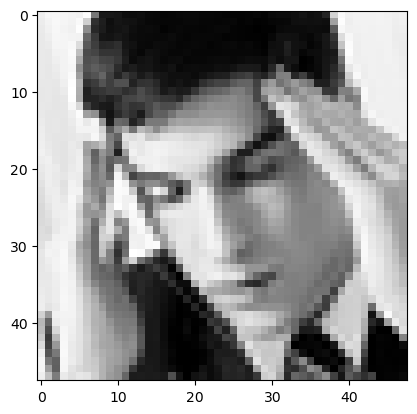

truth: Anger


In [77]:
np_img = test_dataset[0]['image']
plt.imshow(np.transpose(np_img, (1, 2, 0)))
print('image:\n')
plt.show()
plt.close()
print('truth:', classes[test_dataset[6]['emotions'].argmax(0)])

In [74]:
# test model on the test data set
import torch.nn.functional as F
import torch
def test_model(model, test_loader, dataset):
    model.to('cpu')
    model.eval()
    test_loss = 0
    correct = 0
    with torch.inference_mode():
        for data in test_loader:
            labels = data['emotions']
            inputs = data['image']
            output = model(inputs)
            print(labels.shape)
            # show the first 10 images and their truth labels and their predictions
            for i in range(10):
                print('image:', i)
                # print(labels[i].argmax().item())
                print('truth:', classes[labels[i].argmax(0).item()])
                print('prediction:', classes[output[i].argmax(0).item()])
                print('-'*50)
            #     np_img = test_dataset[i]['image']
            #     plt.imshow(np.transpose(np_img, (1, 2, 0)))
            #     plt.show()
            # plt.close('all')    
test_model(model, testloader, test_dataset)

torch.Size([32, 10])
image: 0
truth: Sadness
prediction: Neutral
--------------------------------------------------
image: 1
truth: Neutral
prediction: Neutral
--------------------------------------------------
image: 2
truth: Surprise
prediction: Neutral
--------------------------------------------------
image: 3
truth: Anger
prediction: Anger
--------------------------------------------------
image: 4
truth: Neutral
prediction: Neutral
--------------------------------------------------
image: 5
truth: Happinnes
prediction: Happinnes
--------------------------------------------------
image: 6
truth: Anger
prediction: Anger
--------------------------------------------------
image: 7
truth: Happinnes
prediction: Happinnes
--------------------------------------------------
image: 8
truth: Happinnes
prediction: Happinnes
--------------------------------------------------
image: 9
truth: Happinnes
prediction: Happinnes
--------------------------------------------------
torch.Size([32, 10])